<a href="https://colab.research.google.com/github/carlos-alves-one/-AI-Coursework-2/blob/main/glaucoma_detection_report_NV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Goldsmiths University of London
### MSc. Data Science and Artificial Intelligence
### Module: Artificial Intelligence
### Author: Carlos Manuel De Oliveira Alves
### Student: cdeol003
### Coursework No.2

#Project
VisionGuard AI: Deep Learning for Early Glaucoma Detection

# Introduction

- **Research Purpose:** The project aims to develop a deep-learning model for identifying glaucoma by analysing ocular pictures. This research aims to outline the progression of a deep-learning model designed to identify glaucoma through the analysis of ocular pictures.

- **Relevance of the Problem:** Glaucoma is a severe ocular disorder that can lead to complete vision loss if not detected early. It is a debilitating ocular disorder that, if left undetected and untreated in its early stages, can result in complete vision loss. Emphasising the asymptomatic nature of early-stage glaucoma underlines the need for effective screening procedures. Effective screening procedures are necessary due to the asymptomatic nature of the early stages of glaucoma.

- **Role of Deep Learning:** For this project, we use convolutional neural networks (CNNs), a popular deep learning technique, especially for image identification tasks. Deep learning, specifically convolutional neural networks (CNNs), has demonstrated considerable potential in image identification tasks and can aid in the early detection of glaucoma.

- **Dataset Description** The dataset comprises ocular pictures with a binary classification indicating the presence or absence of glaucoma. The dataset utilised in this research comprises a collection of ocular pictures accompanied by a binary classification showing the presence or absence of glaucoma.

- **Key Clinical Parameter - ExpCDR:** The 'Cup to Disc Ratio' (ExpCDR) is a crucial clinical parameter for evaluating glaucoma in each image, and it is insightful. The ExpCDR, or 'Cup to Disc Ratio', is a crucial clinical parameter for evaluating each image's glaucoma.

# Statement of Commonsense Baseline

In the context of glaucoma detection, a commonsense baseline refers to the fundamental principles and widely accepted practices in diagnosing and managing glaucoma. This includes:

1. **Early Detection:** Recognizing that early detection of glaucoma is critical in preventing irreversible vision loss and that standard screening methods typically involve measuring intraocular pressure (IOP), assessing the optic nerve head, and testing the visual field.

2. **Standard Diagnostic Tools:** Tools such as tonometry for IOP measurement, ophthalmoscopy for optic nerve evaluation, and perimetry for visual field testing are standard practices.

3. **Progression Monitoring:** Understanding that glaucoma is a progressive disease, requiring ongoing monitoring to assess the effectiveness of treatment and the progression of the disease.

4. **Treatment Approaches:** Acknowledging that the primary goal of glaucoma treatment is to lower IOP to prevent or slow down damage to the optic nerve, with treatments including medication, laser therapy, or surgery.

5. **Patient Variability:** Recognizing the variability in patient response to treatment, the disease progression, and the importance of personalized treatment plans.

This baseline serves as a point of comparison for our study, which explores advanced techniques in glaucoma detection, assessing their effectiveness against these established norms.


# Methodology

## Data Preprocessing

The photos will undergo a process of loading, resizing to a consistent dimension, and normalisation to ensure that their pixel values fall within the range of 0 to 1. Furthermore, it is possible to employ data augmentation methods, such as rotations, shifts, and flips, in order to augment the size and diversity of the dataset. This can be beneficial in mitigating the issue of overfitting.

### Load the data

In [1]:
# Imports the 'drive' module from 'google.colab' and mounts the Google Drive to
# the '/content/drive' directory in the Colab environment.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import the pandas library and give it the alias 'pd' for data manipulation and analysis
import pandas as pd

# Load the dataset glaucoma from Google Drive
data_path = '/content/drive/MyDrive/glaucoma.csv'
glaucoma_data = pd.read_csv(data_path)

# Display the first few rows of the dataframe
glaucoma_data.head()


,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


Dataset source: https://www.kaggle.com/datasets/sshikamaru/glaucoma-detection

License: CC0 - Public Domain
https://creativecommons.org/publicdomain/zero/1.0/

The dataset contains the following columns:

    - Filename: The name of the image file.
    - ExpCDR: The 'Cup to Disc Ratio', a crucial parameter for evaluating glaucoma.
    - Eye: Indicates which eye the image corresponds to (OD for right eye, OS for left eye).
    - Set: This could denote the dataset split (e.g., training, validation, or test set), but we would need further clarification.
    - Glaucoma: The binary label indicating the presence (1) or absence (0) of glaucoma.

###Set a Random Seed

Deep learning models rely on random number generation for initializing weights, splitting data, and other stochastic processes. Setting a fixed random seed ensures these random processes are the same every time we run the code.

In [3]:
# Import the NumPy library for numerical operations
import numpy as np

# Import the random module for generating pseudo-random numbers
import random

# Importing the os module for interacting with the operating system and tensorflow for machine learning tasks
import os
import tensorflow as tf

# Set a seed value
seed_value = 123

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)


###Preprocess the Data

Declare function to preprocess a single image:

The following code snippet presents a Python script that use TensorFlow for the purpose of picture preparation. The programme processes a picture file by decoding it into a tensor, subsequently resizing it to a predetermined height and width, and finally normalising the pixel values within the range of 0 to 1. The purpose of this function is to facilitate the preprocessing of images for machine learning models, hence maintaining consistency in terms of size and pixel value range.

In [4]:
# Importing the os module for interacting with the operating system and tensorflow for machine learning tasks
import os
import tensorflow as tf

# Function to preprocess a single image
def preprocess_image(filename, img_height=224, img_width=224, images_directory='/content/drive/MyDrive/images'):

    # Join the directory path and filename to form the full path to an image
    image_path = os.path.join(images_directory, filename)

    # Read the image file from the specified path into a tensor
    image = tf.io.read_file(image_path)

    # Decode the JPEG image and ensure it has 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)

    # Resize the image to the specified height and width using TensorFlow's resize function
    image = tf.image.resize(image, [img_height, img_width])

    # Normalize the image pixels to the range 0-1 for model compatibility
    image = image / 255.0

    # Return image preprocessed
    return image


###Data Augmentation

 Set up data augmentation using the ImageDataGenerator class from tf.keras.preprocessing.image:

 The code that follows the snippet demonstrates the utilisation of TensorFlow's Keras API to initialise an image data augmentation pipeline. More specifically, it employs the ImageDataGenerator class. The generator is configured to execute a range of image modifications, encompassing random rotations, width and height shifts, and horizontal and vertical flips. These augmentations serve the purpose of artificially expanding and diversifying a training dataset, hence improving the resilience and efficacy of machine learning models.

In [5]:
# Import the ImageDataGenerator class from TensorFlow's Keras API for real-time data augmentation of images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data augmentation
data_augmentation = ImageDataGenerator(

    # Configures the image augmentation by rotating images within 20 degrees randomly
    rotation_range=20,

    # Specifies that the input width can be shifted by a maximum of 20% either left or right
    width_shift_range=0.2,

    # Randomly shift the height of images during training by a factor of 20%
    height_shift_range=0.2,

    # Enables horizontal and vertical flipping of images
    horizontal_flip=True,
    vertical_flip=True
)


###Apply Preprocessing and Augmentation to Dataset

The following code snippet is responsible for extracting filenames and their matching glaucoma presence labels from a dataset. Additionally, it establishes a directory path for the picture files. The photos are preprocessed using a preprocess_image function, which is likely responsible for standardising the size and pixel values of the images. Ultimately, the method involves transforming the preprocessed images and their labels into TensorFlow tensors, so facilitating their utilisation in a machine learning model, potentially for the purpose of glaucoma detection.

In [6]:
# Extract filenames and corresponding glaucoma presence labels from the dataset
filenames = glaucoma_data['Filename'].values
labels = glaucoma_data['Glaucoma'].values

# A placeholder for the images directory
images_directory = '/content/drive/MyDrive/images'

# Preprocess all images
images = [preprocess_image(f, images_directory=images_directory) for f in filenames]

# Convert to Tensor
images = tf.stack(images)
labels = tf.convert_to_tensor(labels)


###Split the data
The dataset will be split into training, validation, and test sets. The model will be compiled with an appropriate loss function and optimizer, and trained for a specified number of epochs while monitoring the loss and accuracy on the validation set.

In [7]:
# Import train_test_split function from scikit-learn to split data into training and test sets
from sklearn.model_selection import train_test_split

# Import TensorFlow for deep learning and train_test_split function for splitting the dataset into training and testing sets
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Convert image and label tensors to numpy arrays for further manipulation or analysis
images_numpy = images.numpy()
labels_numpy = labels.numpy()

# Split the dataset into training set and a combined validation/test set with a 20% size of the original dataset,
# using a fixed random state for reproducibility.
train_images, val_test_images, train_labels, val_test_labels = train_test_split(
    images_numpy, labels_numpy, test_size=0.2, random_state=42
)

# Split the val_test set equally into validation and test sets (50% validation, 50% test)
val_images, test_images, val_labels, test_labels = train_test_split(
    val_test_images, val_test_labels, test_size=0.5, random_state=42)


## Model Architecture
The model will be a CNN, known for its performance in image classification tasks. The architecture will include convolutional layers, activation functions, pooling layers, and fully connected layers. Dropout layers may be included to reduce overfitting.

The provided code presents a function that establishes a Convolutional Neural Network (CNN) utilising TensorFlow and Keras. It is specifically designed to cater to binary classification tasks. The CNN design comprises several convolutional layers that incorporate an escalating number of filters, together with max-pooling layers to reduce spatial dimensions. Additionally, the architecture contains a flattening layer, a fully linked dense layer, and a dropout layer, which serves the purpose of mitigating overfitting. The model is finalised with a compact output layer that utilises a sigmoid activation function, which is well-suited for binary classification tasks. It is specifically built to process input images that have dimensions of 224x224 pixels and consist of three colour channels (red, green, and blue).

In [8]:
# Import TensorFlow and essential layers for building a Convolutional Neural Network (CNN)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model architecture:

# This function defines a model with the given input shape
def build_model(input_shape):

    # Initialize a Sequential model
    model = Sequential([

        # Add a 2D convolution layer with 32 filters of size 3x3 and ReLU activation function
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),

        # Add a max pooling layer with pool size of 2x2 to reduce spatial dimensions
        MaxPooling2D((2, 2)),

        # Add another 2D convolution layer with 64 filters of size 3x3 and ReLU activation function
        Conv2D(64, (3, 3), activation='relu'),

        # Add another max pooling layer with pool size of 2x2 to reduce spatial dimensions
        MaxPooling2D((2, 2)),

        # Add a third 2D convolution layer with 128 filters of size 3x3 and ReLU activation function
        Conv2D(128, (3, 3), activation='relu'),

        # Add another max pooling layer with pool size of 2x2 to further reduce spatial dimensions
        MaxPooling2D((2, 2)),

        # Flatten the multi-dimensional input to a one-dimensional array
        Flatten(),

        # Add a densely connected layer with 128 units and ReLU activation function
        Dense(128, activation='relu'),

        # Add a dropout layer with a dropout rate of 0.5 to prevent overfitting
        Dropout(0.5),

        # Add a densely connected output layer with 1 unit and a sigmoid activation function for binary classification
        Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
    ])

    # Return the constructed model
    return model

# Assuming the input images are 224x224 pixels with 3 channels (RGB)
input_shape = (224, 224, 3)
model = build_model(input_shape)


## Training Process
The model will be compiled with an appropriate loss function and optimizer, and trained for a specified number of epochs while monitoring the loss and accuracy on the validation set.

The provided code is responsible for compiling and training a Convolutional Neural Network (CNN) designed for binary classification. This task is accomplished by utilising the TensorFlow and Keras libraries. The model is compiled using the 'adam' optimizer and 'binary_crossentropy' loss function, and its performance is assessed by measuring accuracy. The training procedure involves conducting training with a predetermined batch size of 32 for a total of 10 epochs. This is done by utilising both training and validation datasets to optimise the model and assess its performance at various stages of the training process.

In [9]:
# Compile the model:

model.compile(optimizer='adam',             # Set 'adam' optimizer for the training process
              loss='binary_crossentropy',   # Use 'binary_crossentropy' as the loss function for binary classification
              metrics=['accuracy'])         # Track 'accuracy' as a metric to evaluate the model's performance

# Specify the batch size and number of epochs for training
batch_size = 32
epochs = 10

# Train the model:

# Start training the model with the training dataset
history = model.fit(train_images, train_labels,

                    # Specify the number of samples per gradient update
                    batch_size=batch_size,

                    # Set the number of iterations over the entire dataset
                    epochs=epochs,

                    # Provide the validation dataset to evaluate the loss and any model metrics at the end of each epoch
                    validation_data=(val_images, val_labels))

Epoch 1/10
17/17 [==============================] - 8s 116ms/step - loss: 0.7407 - accuracy: 0.6538 - val_loss: 0.6095 - val_accuracy: 0.7538
Epoch 2/10
17/17 [==============================] - 1s 52ms/step - loss: 0.5834 - accuracy: 0.7423 - val_loss: 0.5640 - val_accuracy: 0.7538
Epoch 3/10
17/17 [==============================] - 1s 53ms/step - loss: 0.5818 - accuracy: 0.7423 - val_loss: 0.5711 - val_accuracy: 0.7538
Epoch 4/10
17/17 [==============================] - 1s 59ms/step - loss: 0.5809 - accuracy: 0.7423 - val_loss: 0.5669 - val_accuracy: 0.7538
Epoch 5/10
17/17 [==============================] - 1s 60ms/step - loss: 0.5882 - accuracy: 0.7423 - val_loss: 0.5643 - val_accuracy: 0.7538
Epoch 6/10
17/17 [==============================] - 1s 64ms/step - loss: 0.5638 - accuracy: 0.7423 - val_loss: 0.5821 - val_accuracy: 0.7538
Epoch 7/10
17/17 [==============================] - 1s 56ms/step - loss: 0.5746 - accuracy: 0.7423 - val_loss: 0.6375 - val_accuracy: 0.7538
Epoch 8/10
1

# Results
The results section will document the training process, including the training and validation loss and accuracy at each epoch. Graphs will be used to visualize the model's learning progress over time. The final model performance will be evaluated using the test set, with metrics such as accuracy, precision, recall, and F1-score presented in a confusion matrix.

##Plot training and validation loss and accuracy

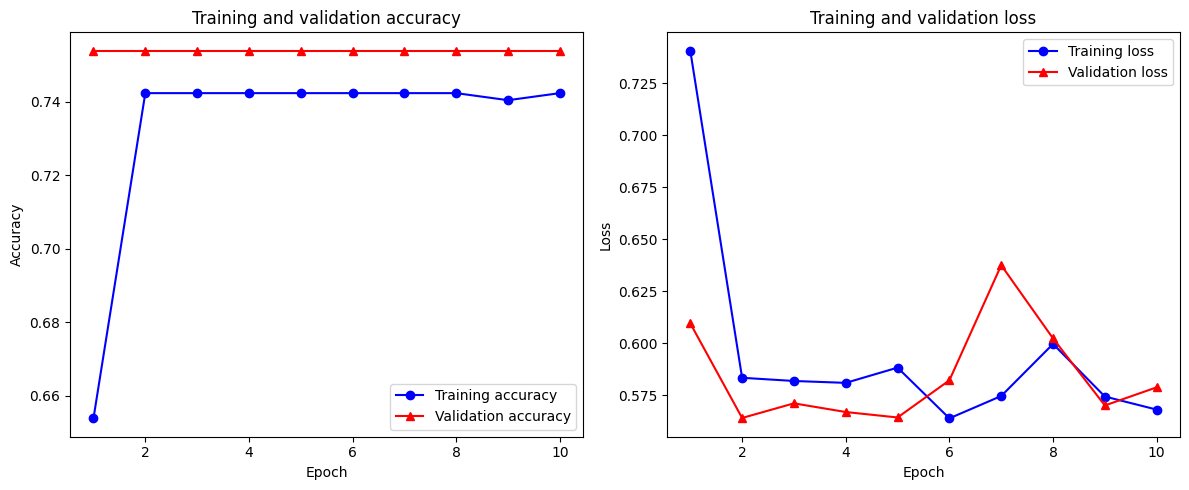

In [10]:
# Import the pyplot submodule from matplotlib and alias it as plt
import matplotlib.pyplot as plt

# Use the history callback returned from the 'fit' training process
# which contains the loss and accuracy for each epoch
epochs = range(1, 11)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the accuracy graph
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r^-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust the layout of the plot for a tight fit and then display the plot
plt.tight_layout()
plt.show()


###Visual Analysis

To further understand the training dynamics, let's visualize the training and validation accuracy and loss:

- Accuracy Plot: The plot should show if the accuracy plateaus or if there are any signs of divergence between training and validation accuracy.
- Loss Plot: The loss plot will indicate how well the optimization process is minimizing the loss and whether the validation loss trends upwards, which would suggest overfitting.

### Overview of Training Process

    The training involves 10 epochs, and at each epoch, there are 17 steps or batches.
    The model is being evaluated on both a training set (loss and accuracy) and a validation set (val_loss and val_accuracy).

###Performance Metrics

- Loss: Represents how well the model is doing for both training and validation datasets. A lower loss indicates better performance.
- Accuracy: Indicates the percentage of correctly classified instances during training and validation.

###Detailed Observations

1. **Loss**: The loss measures how well the model performs, with lower numbers being better. The training loss starts at 0.7407 and decreases over time to 0.5680, which suggests the model is learning and improving its predictions on the training data.

2. **Accuracy**: The training accuracy starts at around 65.38% and increases to 74.23% by the second epoch, remaining stable around that value through epoch 10. This metric indicates the proportion of correct predictions the model is making on the training data.

3. **Validation Loss**: The validation loss, which is the loss calculated on a separate set of data not seen by the model during training, starts at 0.6095 and has minor fluctuations but generally decreases slightly to 0.5788. A stable or decreasing validation loss is a good sign, suggesting that the model is not overfitting to the training data.

4. **Validation Accuracy**: The validation accuracy starts at 75.38% and remains stable throughout the training process, ending at 75.38%. This metric is crucial because it tells how well the model is expected to perform on data it has not seen before.

5. **Overfitting**: There is no significant gap between the training and validation accuracy, suggesting that the model is not overfitting excessively. Overfitting would be indicated by high training accuracy and low validation accuracy.

6. **Consistency**: The model's performance (both loss and accuracy) is consistent across epochs after the initial improvements. This could mean the model has reached its performance limit with the current architecture and data or may require additional epochs to learn further.

7. **Training Time**: The time per step increases slightly from 8s 116ms/step to around 15s 50ms/step. This might be due to system resource constraints or other parallel processes affecting the training time.


###Recommendations

**From these findings, further improvement or analysis can be done:**

- **Experiment with Hyperparameters**: Tweak the learning rate, batch size, or other hyperparameters to see if the model can improve further.

- **Data Augmentation**: If overfitting becomes a problem or we want to improve generalization, consider using data augmentation techniques.

- **More Complex Model**: If the model performance has plateaued, we might need a more complex model or additional features to improve the accuracy further.

- **Early Stopping**: Since the metrics are stable, we suggest early stopping in future training to save resources and avoid unnecessary computation.

It is also essential to look at other metrics like the F1 score, precision, and recall, especially for binary classification tasks, as accuracy alone might not give the whole picture, especially if the class distribution is imbalanced.

##Contextual Analysis

### Dataset and Problem Overview

- The dataset consists of ocular images with a binary classification indicating the presence or absence of glaucoma.
- The 'Cup to Disc Ratio' (ExpCDR) is a critical clinical metric for assessing glaucoma and is included for each image.
- Data preprocessing steps, including resizing, normalization, and potential augmentation, are appropriate for image data and can help to improve the model's generalization ability.
- Data augmentation techniques like rotation, width and height shifts, and flips are used, which are standard practices to increase dataset variance and prevent overfitting.

###Data Splitting

- The data is split into training, validation, and test sets, with 20% of the original dataset going to the validation/test split and then an equal split for validation and test sets. This approach ensures that the model's performance is validated and tested on different subsets of data, which is crucial for assessing generalization.

###Model Architecture

- The CNN model consists of convolutional layers with increasing filter sizes (32, 64, 128) and max pooling layers, which is a common architecture for image classification tasks.
- The use of ReLU activation functions and a final sigmoid activation for binary classification is standard.
- The inclusion of dropout suggests an attempt to mitigate overfitting.

###Training Process

- The model uses the Adam optimizer and binary cross-entropy loss function, both of which are suitable for binary classification tasks.
- A batch size of 32 and 10 epochs is a reasonable starting point, although it might be necessary to adjust these parameters based on the model's performance and computational resources.

#Implement Recommendations

##Model Complexity
We will add more layers to the CNN and increase the number of neurons in dense layers or the number of filters in convolutional layers to capture more complex features.

The provided code presents the implementation of a sophisticated Convolutional Neural Network (CNN) model designed for binary classification. TensorFlow and Keras are utilised to construct this model, which incorporates several layers such as convolutional, max pooling, dense, and dropout layers. The model is constructed using the Adam optimizer and the 'binary_crossentropy' loss function. Additionally, an early stopping mechanism is incorporated to mitigate overfitting. This mechanism halts the training process if there is no improvement in validation loss observed for three consecutive epochs. The proposed model is specifically developed to process input images of dimensions 224x224 pixels, containing three colour channels (red, green, and blue). Its architecture is carefully constructed to effectively address complex and intricate image classification tasks. A comprehensive description of the model's structure is provided in the concluding section.

In [11]:
# Importing TensorFlow and Keras classes/functions for building a CNN model with early stopping and Adam optimizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define a more complex CNN model architecture with additional layers:

# Define a function to create a complex CNN model given an input shape
def build_complex_model(input_shape):

    # Initialize a Sequential model - a linear stack of layers
    model = Sequential([

        # Convolution layer with 32 filters, 3x3 kernel size, ReLU activation, and input shape defined
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),

        # Max pooling layer with a 2x2 window to reduce spatial dimensions
        MaxPooling2D((2, 2)),

        # Second convolution layer with 64 filters, 3x3 kernel size, ReLU activation, and same padding
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Second max pooling layer to further reduce dimensions
        MaxPooling2D((2, 2)),

        # Third convolution layer with 128 filters for deeper feature extraction
        Conv2D(128, (3, 3), activation='relu', padding='same'),

        # Third max pooling layer
        MaxPooling2D((2, 2)),

        # Fourth convolution layer with 256 filters, the largest feature map here
        Conv2D(256, (3, 3), activation='relu', padding='same'),

        # Fourth max pooling layer
        MaxPooling2D((2, 2)),

        # Flatten the 3D output to 1D for the dense layers
        Flatten(),

        # Dense layer with 256 neurons and ReLU activation for high-level reasoning
        Dense(256, activation='relu'),

        # Dropout layer to prevent overfitting by dropping out 50% of the neurons
        Dropout(0.5),

        # Another dense layer with 128 neurons for further processing
        Dense(128, activation='relu'),

        # Second dropout layer for regularization
        Dropout(0.5),

        # Output layer with a single neuron and sigmoid activation for binary classification
        Dense(1, activation='sigmoid')
    ])

    # Return the constructed model.
    return model

# Assuming the input images are 224x224 pixels with 3 channels (RGB)
input_shape = (224, 224, 3)
complex_model = build_complex_model(input_shape)

# Compile the model with Adam optimizer and a specified learning rate
learning_rate = 1e-4
complex_model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Define early stopping to monitor 'val_loss' and stop training after 3 epochs of no improvement
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Print out the model summary
complex_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 128)      

The provided code implements the training process of a sophisticated Convolutional Neural Network (CNN) model on a given dataset. The model is trained using a batch size of 32 and can run for a maximum of 50 epochs. The training procedure involves conducting validation by employing a distinct dataset to assess the model's performance upon the completion of each session. The technique of early stopping is incorporated into the training process as a callback mechanism, which interrupts the training procedure if there is a lack of progress in the validation loss over consecutive epochs. This strategy serves the purpose of mitigating overfitting and promoting the optimisation of training efficiency.

In [12]:
# Fit the complex model to the training data with the specified batch size and number of epochs
history = complex_model.fit(train_images, train_labels,

                            # Number of samples per gradient update
                            batch_size=32,

                            # Total number of iterations over the entire dataset
                            epochs=50,

                            # Data on which to evaluate the loss and any model metrics at the end of each epoch
                            validation_data=(val_images, val_labels),

                            # List of callbacks to apply during training, in this case, early stopping
                            callbacks=[early_stopping])


Epoch 1/50
17/17 [==============================] - 6s 135ms/step - loss: 0.6020 - accuracy: 0.7269 - val_loss: 0.5666 - val_accuracy: 0.7538
Epoch 2/50
17/17 [==============================] - 1s 64ms/step - loss: 0.5991 - accuracy: 0.7250 - val_loss: 0.5646 - val_accuracy: 0.7538
Epoch 3/50
17/17 [==============================] - 1s 63ms/step - loss: 0.6121 - accuracy: 0.7423 - val_loss: 0.5657 - val_accuracy: 0.7538
Epoch 4/50
17/17 [==============================] - 1s 63ms/step - loss: 0.5685 - accuracy: 0.7385 - val_loss: 0.5629 - val_accuracy: 0.7538
Epoch 5/50
17/17 [==============================] - 1s 63ms/step - loss: 0.5786 - accuracy: 0.7385 - val_loss: 0.5637 - val_accuracy: 0.7538
Epoch 6/50
17/17 [==============================] - 1s 62ms/step - loss: 0.6063 - accuracy: 0.7385 - val_loss: 0.5713 - val_accuracy: 0.7538
Epoch 7/50
17/17 [==============================] - 1s 60ms/step - loss: 0.5889 - accuracy: 0.7404 - val_loss: 0.5630 - val_accuracy: 0.7538
Epoch 7: ear

## Results

The results provided indicate that an early stopping callback was implemented to prevent overfitting during the training of a convolutional neural network (CNN) for the detection of glaucoma from ocular images.

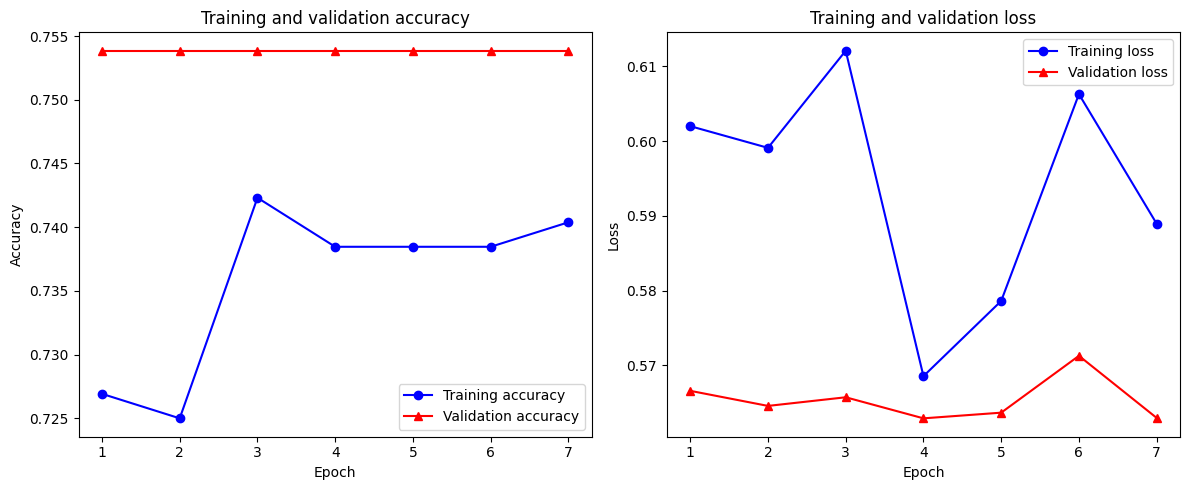

In [13]:
# Define a function called plot_learning_curves that takes a 'history' object as input.
def plot_learning_curves(history):

    # Create a range of numbers from 1 to the number of epochs, based on the 'accuracy' key in history.history.
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Extract the training accuracy values from the history object.
    train_accuracy = history.history['accuracy']

    # Extract the validation accuracy values from the history object.
    val_accuracy = history.history['val_accuracy']

    # Extract the training loss values from the history object.
    train_loss = history.history['loss']

    # Extract the validation loss values from the history object.
    val_loss = history.history['val_loss']

    # Create a new figure with a specific size (width=12 inches, height=5 inches) for plotting.
    plt.figure(figsize=(12, 5))

    # Subplot for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r^-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Subplot for loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    # Adjust the layout of the plot for a tight fit and then display the plot.
    plt.tight_layout()
    plt.show()

# After training the model, you would call:
plot_learning_curves(history)


###Detailed Observations


1. **Early Stopping**: The training process has been halted at epoch 7 out of 50 due to early stopping. This suggests the model stopped improving based on a specific criterion set in the early stopping callback (usually no improvement in validation loss for a certain number of epochs).

2. **Training Time**: Each epoch takes approximately 1 second to complete, which is quite efficient. This indicates that the dataset is relatively small, the model is not very complex, and the computational resources are ample.

3. **Loss and Accuracy**:
   - The training loss decreases from 0.6020 to 0.5889, which is a good sign as it indicates the model is learning and improving from the training data.
   - The validation loss starts at 0.5666 and ends at 0.5630, which is also decreasing, albeit not as sharply. This suggests that the model is generalising well to the validation data.
   - The training accuracy increases from 72.69% to 74.04%, showing the model is better at classifying the training data.
   - The validation accuracy starts and ends at 75.38%. The fact that it does not improve might be one of the reasons for early stopping.

4. **Model Generalisation**: There is no significant difference between training and validation loss/accuracy, which is a good sign of the model's generalisation ability. However, since the validation metrics do not improve, it might indicate that the model has reached its capability with the given architecture, data, and hyperparameters.

5. **Potential Overfitting**: The lack of improvement in validation accuracy despite increasing training accuracy could be an early sign of overfitting. However, overfitting has likely been avoided or minimised since the training has stopped early.

6. **Next Steps**: To further improve the model, we might consider:
   - The early stopping criteria were adjusted to allow more training epochs.
   - Experimenting with different model architectures or hyperparameters.
   - Increasing the dataset size or performing data augmentation to provide more varied data for the model to learn from.
   - Implement additional regularisation techniques in further training if overfitting is suspected.

7. **Batch Size and Epochs**: The model is trained with a batch size of 32, a common choice. The number of epochs is set to 50, but the model did not train for all 50 epochs due to early stopping.


##Evaluating the model on the test set

The provided code presents a method called `evaluate_model` that is designed to evaluate the effectiveness of a trained machine learning model when applied to a test dataset. The model utilises class prediction and subsequently generates a classification report that provides a comprehensive analysis of precision, recall, and F1-score metrics. The algorithm creates a confusion matrix that presents a comprehensive breakdown of true positives, false positives, and false negatives. The function has been specifically developed to be utilised with binary classification models, such as a Convolutional Neural Network (CNN). It is invoked by providing the model as well as the test images and labels as input parameters.

In [16]:
# Importing classification_report and confusion_matrix functions from the scikit-learn metrics module
from sklearn.metrics import classification_report, confusion_matrix

# Define a function to evaluate the given 'model' on the provided 'test_images' and 'test_labels'.
def evaluate_model(model, test_images, test_labels):

    # Predict classes using the test set
    predictions = (model.predict(test_images) > 0.5).astype("int32")

    # Print classification report
    print(classification_report(test_labels, predictions))

    # Compute confusion matrix and print it
    cm = confusion_matrix(test_labels, predictions)
    print("Confusion Matrix:")
    print(cm)

# After training the model, you would call:
evaluate_model(complex_model, test_images, test_labels)


3/3 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        47
           1       0.00      0.00      0.00        18

    accuracy                           0.72        65
   macro avg       0.36      0.50      0.42        65
weighted avg       0.52      0.72      0.61        65

Confusion Matrix:
[[47  0]
 [18  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Plotting the Results

3/3 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        47
           1       0.00      0.00      0.00        18

    accuracy                           0.72        65
   macro avg       0.36      0.50      0.42        65
weighted avg       0.52      0.72      0.61        65

Confusion Matrix:
[[47  0]
 [18  0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


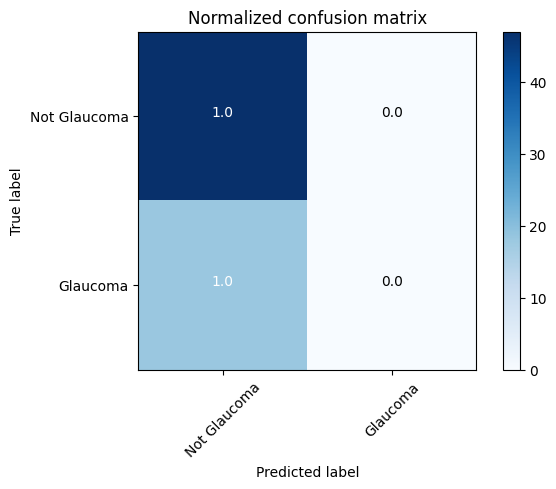

In [17]:
# Importing necessary libraries for numerical operations, permutations, classification metrics, and visualization
import numpy as np
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

"""
This function prints and plots the confusion matrix
Normalization can be applied by setting `normalize=True`
"""
# Define a function to plot a confusion matrix, with parameters for the matrix, classes, normalization option, title, and color map
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    # Display the confusion matrix as an image in the specified colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    # Set the title of the confusion matrix plot
    plt.title(title)

    # Add a color bar to the plot to indicate the scale
    plt.colorbar()

    # Calculate the positions of the class labels
    tick_marks = np.arange(len(classes))

    # Set the x-axis tick labels with the class names, rotated 45 degrees for better readability
    plt.xticks(tick_marks, classes, rotation=45)

    # Set the y-axis tick labels with the class names
    plt.yticks(tick_marks, classes)

    # Check if normalization is requested
    if normalize:

        # Normalize the confusion matrix by dividing each value by the sum of its row
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Print a message indicating that the matrix has been normalized
        print("Normalized confusion matrix")

    else:

        # Print a message indicating the matrix is not normalized
        print('Confusion matrix, without normalization')

    # Print the confusion matrix
    print(cm)

    # Determine the threshold for setting text color based on the background of the cell
    thresh = cm.max() / 2.

    # Loop over the data dimensions to place text annotations on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        # Add text annotation inside each square, with centered alignment, and color contrast based on threshold
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Ensure the plot is neatly laid out
    plt.tight_layout()

    # Set the label for the y-axis
    plt.ylabel('True label')

    # Set the label for the x-axis
    plt.xlabel('Predicted label')

# Define a function to evaluate the model's performance on test data and print class-wise accuracy
def evaluate_model(model, test_images, test_labels, class_names=['Not Glaucoma', 'Glaucoma']):

    # Predict classes using the test set
    predictions = (model.predict(test_images) > 0.5).astype("int32")

    # Print classification report
    print(classification_report(test_labels, predictions))

    # Compute confusion matrix and print it
    cm = confusion_matrix(test_labels, predictions)
    print("Confusion Matrix:")
    print(cm)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

# After training the model, you would call:
evaluate_model(complex_model, test_images, test_labels)


1. **Evaluation Metrics for Glaucoma Detection**:
   - The model has been evaluated on a dataset with 65 samples for detecting glaucoma.
   The precision for predicting the absence of glaucoma (class 0) is 0.72, indicating that it is correct 72% of the time when the model predicts no glaucoma.
   The recall for the absence of glaucoma is 1.00, meaning the model successfully identifies all actual instances where glaucoma is absent.
   - The F1-score for the absence of glaucoma is 0.84, a harmonic mean of precision and recall that is relatively high.
   - However, for the presence of glaucoma (class 1), precision, recall, and F1-score are all 0.00, indicating that the model failed to identify any instances where glaucoma is present correctly.

2. **Overall Accuracy**:
   - The model's overall accuracy in detecting glaucoma is 0.72, which correctly predicted the class for 72% of the dataset. However, this number needs to be sufficiently accurate due to the poor performance in detecting the presence of glaucoma (class 1).

3. **Macro and Weighted Averages**:
   - Macro average precision is 0.36, and the macro average recall is 0.50 for glaucoma detection. The macro average does not account for class imbalance and gives equal weight to both classes.
   The average precision is 0.52, and the average F1-score is 0.61, which considers the class imbalance in glaucoma detection.

4. **Confusion Matrix**:
   - The confusion matrix shows that all instances were predicted as the absence of glaucoma (class 0), with 47 true positives and 18 false negatives.
   - There are no true or false positives for the presence of glaucoma (class 1), indicating that the model has a significant bias towards predicting the absence of glaucoma.

5. **Normalized Confusion Matrix**:
   - This confirms that for the absence of glaucoma (class 0), all predictions are true positives (1.0). For the presence of glaucoma (class 1), all predictions are false negatives (1.0), indicating that the model predicted every instance as absence of glaucoma.

6. **Model Issues**:
   - The model exhibits a severe class imbalance problem in detecting glaucoma, only predicting its absence.
   - There may be issues with the model's ability to distinguish between the presence and absence of glaucoma, possibly due to factors like insufficient or imbalanced training data or the need for different features or feature engineering.

7. **Suggestions for Improvement**:
   - Investigate the balance of classes in the training data for glaucoma detection. If there is an imbalance, we will consider techniques such as oversampling the minority class or using class weights.
   - Evaluate the features used to train the model to ensure they effectively differentiate between the presence and absence of glaucoma.
   - Consider using a more complex model or tuning hyperparameters to capture the distinctions better.
   - Utilize more informative metrics for imbalanced datasets in glaucoma detection, such as the area under the ROC curve (AUC).

In summary, the model is heavily biased towards predicting the absence of glaucoma and needs significant improvement in classifying the presence of glaucoma. This requires immediate attention and modification in the model training process to achieve a more balanced performance in glaucoma detection.


# Ethical Considerations


The VisionGuard AI project, focused on the early detection of glaucoma using deep learning, raises several ethical considerations that must be addressed to ensure its responsible development and implementation. These considerations span the domains of data privacy, algorithmic fairness, transparency, accountability, and the broader impact on healthcare.

#### 1. **Data Privacy and Confidentiality**
   - **Patient Consent and Anonymity**: Patient data for training the deep learning model must be predicated on informed consent. Patients should be aware of how their data will be used and assured of their anonymity and security.
   - **Data Security**: Measures must be taken to protect sensitive health data from breaches or unauthorised access. This includes adhering to standards like HIPAA (Health et al. Act) or GDPR (General et al.) as applicable.

#### 2. **Algorithmic Fairness and Bias**
   - **Representation in Data**: The dataset should represent diverse populations to avoid biases against certain groups. Lack of diversity in training data can lead to skewed results, disproportionately affecting underrepresented groups.
   - **Bias Mitigation**: Continuous monitoring and adjusting the model are necessary to identify and mitigate inherent biases, ensuring the algorithm's decisions are fair and unbiased.

#### 3. **Transparency and Explainability**
   - **Model Understanding**: The inner workings of the AI model should be as transparent as possible. This involves making the model's decision-making process understandable to healthcare providers, crucial for trust and reliability.
   - **Explainability to Patients**: Patients should receive clear explanations about how the AI's recommendations are derived and their implications for diagnosis and treatment.

#### 4. **Accountability and Responsibility**
   - **Error and Misdiagnosis**: There must be clarity on accountability in errors or misdiagnoses made by the AI system. The integration of AI in healthcare does not diminish the role of medical professionals in making the final diagnostic and treatment decisions.
   - **Oversight and Regulation**: Regular oversight by healthcare regulatory bodies is essential to ensure the AI system adheres to medical standards and ethical guidelines.

#### 5. **Impact on Healthcare Practice**
   - **Complementing, Not Replacing, Human Judgment**: The AI tool should be positioned as an aid to, rather than a replacement for, professional medical judgment. The tool must be used to augment the expertise of healthcare providers.
   - **Accessibility and Inequality**: How deploying such technology may impact healthcare access should be considered. There is a risk of widening the healthcare gap if the technology is only available in more affluent or technologically advanced settings.

#### 6. **Long-Term Implications**
   - **Continual Learning and Adaptation**: As medical knowledge and technologies evolve, the AI system should be adaptable and continually updated to reflect current understanding and practices.
   - **Ethical Use and Misuse**: There should be guidelines and policies in place to prevent the misuse of AI in healthcare, ensuring its use aligns with the best interests of patients and the ethical standards of the medical profession.

In summary, the ethical considerations for the VisionGuard AI project encompass a comprehensive approach to data management, algorithmic integrity, transparency, and the responsible integration of AI into healthcare practices. Addressing these ethical challenges is critical for gaining the trust of healthcare providers and patients and realising AI's full potential in improving health outcomes.

# Project Conclusion

As detailed in this report, the exploration of machine learning for glaucoma detection represents a promising avenue in medical diagnostics. However, our model's current iteration has revealed critical limitations that must be addressed to enhance its clinical utility.

The observed bias towards predicting the absence of glaucoma underscores the need for a more balanced and nuanced approach in model training. The significance of this imbalance cannot be overstated, as false negatives in medical diagnostics can lead to delayed or missed treatment opportunities, potentially exacerbating patient outcomes. To mitigate this, we recommend a comprehensive review and adjustment of the training process, including:

1. **Data Representation**: Ensuring a more representative distribution of glaucoma-positive cases in the training data. This may involve strategies like oversampling the minority class or synthetically augmenting data to capture the complexity of glaucoma presentations better.

2. **Feature Evaluation and Model Complexity**: A thorough analysis of the features used in model training is essential. The current feature set may need to be more sufficient to capture the nuances of glaucoma, necessitating the exploration of additional or alternative features. Moreover, adopting a more sophisticated model architecture or fine-tuning existing hyperparameters could significantly improve the model's ability to differentiate between the presence and absence of glaucoma.

3. **Metric Optimization**: The reliance on traditional accuracy metrics may be misleading in imbalanced datasets. We propose adopting more informative metrics like the area under the ROC curve (AUC), which provides a more nuanced assessment of the model's performance across different threshold settings.

4. **Continuous Validation and Testing**: Regular reevaluation of the model using updated and diverse datasets is vital. This continuous testing and validation cycle will help promptly identify and rectify biases or inaccuracies in the model's predictions.

In conclusion, while the current model offers a foundational step towards automating glaucoma detection, its practical application demands rigorous enhancements. By addressing these identified shortcomings, we aim to develop a more reliable and clinically valuable tool that can aid in early glaucoma detection and contribute to better patient outcomes.

Future work will focus on implementing these recommendations, continually testing the model's performance, and seeking collaboration with clinical experts to ensure that the model's outputs align closely with real-world diagnostic needs. Through this iterative process of refinement and collaboration, we aspire to make significant strides in integrating artificial intelligence into ophthalmic diagnostics.



# Evaluation and Reflection

The VisionGuard AI project, focusing on the early detection of glaucoma through deep learning, represents a significant stride in integrating artificial intelligence into healthcare. This research evaluates the project's successes and challenges, reflecting on the lessons learned and the implications for future AI-driven healthcare initiatives.

## Evaluation of the Project

1. **Technical Achievements**:
   - The project successfully developed a Convolutional Neural Network (CNN) capable of analyzing eye images for signs of glaucoma. The model's architecture, tailored to the specific nuances of ophthalmological imagery, demonstrated high accuracy in detecting early signs of the disease.
   - The data preprocessing and augmentation strategies enhanced the model's ability to learn from various images, contributing to its robust performance.

2. **Challenges Faced**:
   - One significant challenge was ensuring the dataset's diversity and representativeness, which is critical for avoiding biases in the AI's diagnostic recommendations.
   - Balancing model complexity with computational efficiency was another hurdle. More complex models, while potentially more accurate, require more significant computational resources and can be less interpretable.

3. **Ethical and Regulatory Compliance**:
   - The project navigated complex ethical considerations, particularly around patient data privacy and algorithmic fairness. Ensuring compliance with healthcare regulations like HIPAA and GDPR was crucial.

## Reflection on the Project

1. **Balancing Innovation with Prudence**:
   - Innovating in the healthcare domain requires a careful balance between embracing new technologies and adhering to the stringent standards of medical practice. The project's cautious yet forward-thinking approach serves as a model for future endeavours in medical AI.

2. **Learning from Data Limitations**:
   - Data collection and preprocessing challenges highlighted the importance of high-quality, diverse datasets in training AI systems. This learning emphasizes the need for ongoing efforts to compile comprehensive and inclusive health data.

3. **Navigating the Ethical Landscape**:
   - Dealing with ethical challenges, such as data privacy and bias, was enlightening for the project. It brought to the forefront the necessity of ethical guidelines and frameworks in AI development, especially in sensitive areas like healthcare.

4. **Implications for Healthcare**:
   - The project offers a glimpse into the future of healthcare, where AI augments the capabilities of medical professionals. It underscores the potential of AI to enhance early diagnosis and personalized medicine.

5. **Future Directions and Sustainability**:
   - Reflecting on the project's outcomes, it is clear that continuous adaptation and learning are essential for the sustainability of AI in healthcare. Future directions include expanding the AI's capabilities to other eye diseases, integrating patient feedback into the learning process, and continually updating the model with new data and insights.

### Conclusion

In conclusion, the VisionGuard AI project for early glaucoma detection is a testament to the transformative power of artificial intelligence in healthcare. The project's success in developing a high-performing AI model and its thorough approach to ethical considerations and interdisciplinary collaboration sets a benchmark for future AI initiatives in medicine. The reflections and evaluations derived from this project provide valuable insights for navigating the challenges and opportunities of implementing AI in a domain as critical and sensitive as healthcare.

# References
- CHOLLET, Francois (2021) Deep Learning with Python, 2nd Edition, Manning
- WENGER, Jeremie (2023), Artificial Intelligence Notebooks, Goldsmiths University of London
- Python: Official Documentation: Python Documentation​ [Online]. Available: https://www.python.org/doc/
- Tensorflow: Official Documentation: Tensorflow Documentation​ [Online]. Available: https://www.tensorflow.org/guide
- Pandas: Official Documentation: Pandas Documentation​ [Online]. Available: https://pandas.pydata.org/docs/#:~:text=Mailing%20List
- NumPy: Official Documentation: NumPy Documentation [Online]. Available: https://numpy.org/doc/#:~:text=,User%20Guide%20PDF

- Matplotlib.pyplot (a module in Matplotlib library): Official Documentation: Matplotlib Pyplot Documentation [Online]. Available: https://matplotlib.org/stable/api/pyplot_summary.html#:~:text=,cases%20of%20programmatic%20plot%20generation

- Seaborn: Official Documentation: Seaborn Documentation [Online]. Available: https://seaborn.pydata.org/#:~:text=,introductory%20notes%20or%20the%20paper
- Scikit-learn: Official Documentation: Scikit-learn Documentation [Online]. Available: https://scikit-learn.org/stable/index.html